In [1]:
import numpy as np
import pandas as pd
from quantbullet.preprocessing import FlatRampTransformer
from sklearn.preprocessing import OneHotEncoder
from quantbullet.linear_product_model import LinearProductModelToolkit, LinearProductRegressorBCD
from quantbullet.parametic_model import AsymQuadModel, BathtubModel
from quantbullet.parametic_model.utils import compare_models

In [2]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos( df['x1'] / 3 ) + np.sin(df['x2'] / 5) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

feature_config = {
    'x1': FlatRampTransformer(
        knots = list( np.arange( 4, 16, 1 ) ),
        include_bias=True
    ),
    'x2': FlatRampTransformer(
        knots = list( np.arange( 14, 26, 1 ) ),
        include_bias=True
    ),
    'x3': OneHotEncoder( drop=None )
}

tk = LinearProductModelToolkit( feature_config ).fit( df )
train_df = tk.get_train_df( df )

In [3]:
model = LinearProductRegressorBCD()

In [4]:
model.fit( train_df, df['y'], feature_groups=tk.feature_groups, n_iterations=20, early_stopping_rounds=5, cache_qr_decomp=False, ftol=1e-8, offset_y=0 )

Iteration 1/20, Loss: 5.025260e-01
Iteration 2/20, Loss: 5.015175e-01
Iteration 3/20, Loss: 5.015175e-01
Iteration 4/20, Loss: 5.015175e-01
Iteration 5/20, Loss: 5.015175e-01
Iteration 6/20, Loss: 5.015175e-01
Iteration 7/20, Loss: 5.015175e-01
Converged at iteration 7 with Loss: 5.0152e-01


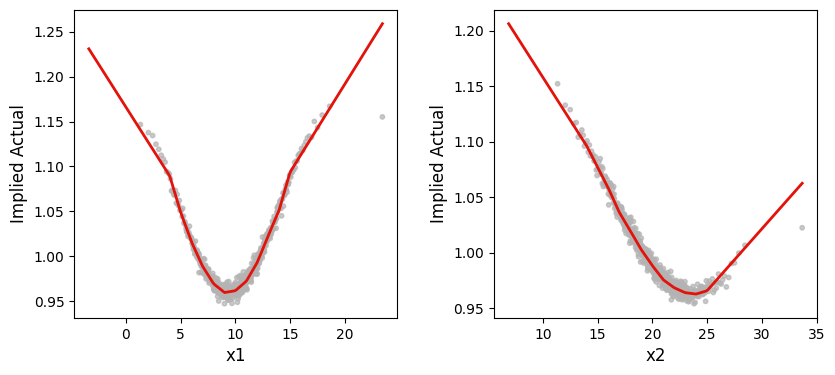

In [5]:
fig, axes, caches = tk.plot_discretized_implied_errors( model, df, df['y'], train_df, sample_frac=1, n_quantile_groups=500, method='bin' )

In [6]:
feature_name = 'x1'
linear_pred = tk.get_single_feature_pred_given_values( feature_name=feature_name, feature_values=caches[feature_name].agg_df['feature_bin_right'], model=model )
x1_implied_actuals = caches[feature_name].agg_df['implied_actual_mean']
x1 = caches[feature_name].agg_df['feature_bin_right']

In [7]:
x1_model = AsymQuadModel( allow_extrapolation=False ).fit( x1, x1_implied_actuals )
x1_model.model_name = "x1-AsymQuadModel"

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

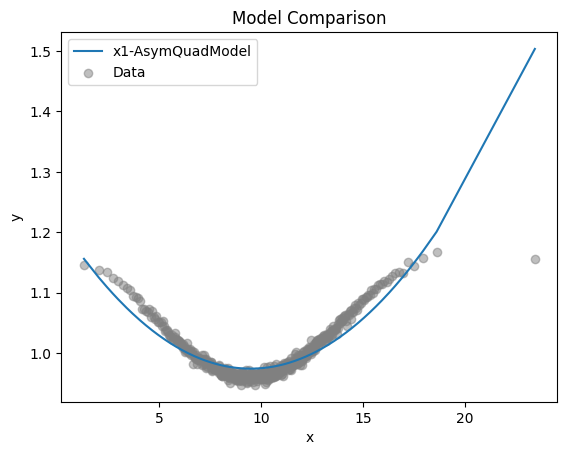

In [8]:
compare_models( models=[x1_model], x=x1, y=x1_implied_actuals )

In [9]:
feature_name = 'x2'
linear_pred = tk.get_single_feature_pred_given_values( feature_name=feature_name, feature_values=caches[feature_name].agg_df['feature_bin_right'], model=model )
x2_implied_actuals = caches[feature_name].agg_df['implied_actual_mean']
x2 = caches[feature_name].agg_df['feature_bin_right']

In [10]:
x2_model = AsymQuadModel( allow_extrapolation=False ).fit( x2, x2_implied_actuals )
x2_model.model_name = "x2-AsymQuadModel"

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

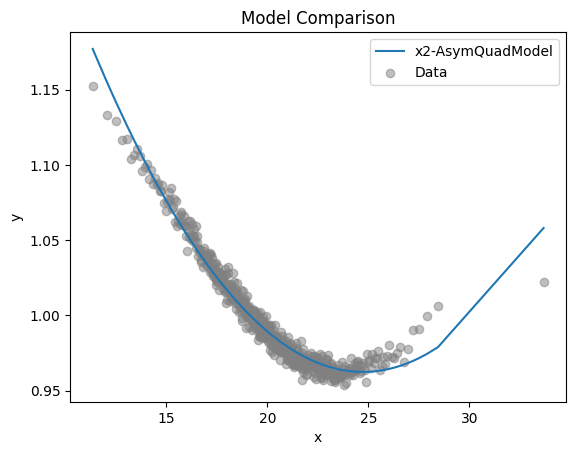

In [11]:
compare_models( models=[x2_model], x=x2, y=x2_implied_actuals )

## Use Parametric Models as Model Components

In [12]:
from quantbullet.linear_product_model import ComponentManager, ComponentConfig, ComponentRegistry

In [13]:
x1_component = ComponentConfig(
    class_name = 'AsymQuadModel',
    args = x1_model.to_dict(),
)

x2_component = ComponentConfig(
    class_name = 'AsymQuadModel',
    args = x2_model.to_dict(),
)

manager = ComponentManager( ComponentRegistry( label='Test' ) )
manager.add_component( "x1", x1_component )
manager.add_component( "x2", x2_component )

manager.to_json( r"test-model-components.json" )

In [14]:
manager.build_all_models()

In [18]:
manager.models['x1']

x1-AsymQuadModel({'a': np.float64(0.0027202450873722857), 'b': np.float64(0.044633337689657444), 'x0': np.float64(17.692910839181476), 'c': np.float64(1.1573768383274763)})